# Empirical Supernova Simulation Demo

_Tom Holoien & Phil Marshall, August 2016_

We'd like to be able to simulate cosmological supernovae in wide field optical imaging surveys so that their properties follow the distributions that have been observed to date. Given a simulated host galaxy, where should we place the mock supernova? And what light curve should it produce?

In this notebook we demonstrate some of the functionality of the `empiriciSN` class, which was developed to solve the above problem. We will demonstrate below how to:

* Select the proper number of components to use in the Extreme Deconvolution Gaussian Mixture Model (XDGMM) for a sample supernova/host dataset using the Bayesian Information Criterion (BIC);

* Fit a model to a given dataset, and read a model that has already been computed;

* Use a model conditioned on a subset of host properties to sample a realistic separation from host nucleus for a given host, and then use that to calculate local host surface brightnesses;

* Sample realistic `SALT2` supernova parameters from a model conditioned on the full set of host properties, including redshift, separation from host, host colors, and local surface brightnesses at the location of the supernova.


## Requirements

You will need to have installed Tom Holoien's `XDGMM` package, as well as its dependencies. See the `README.md` for details.

> By default, in `empiricSN` all the model fitting is done with the [`AstroML`](http://www.astroml.org/index.html) XDGMM algorithm rather than the [Bovy et al. (2011)](https://github.com/jobovy/extreme-deconvolution) algorithm - for this demo you do not need to have the Bovy et al. algorithm installed to run the code. However, we note that the Bovy et al. algorithm is, in general, significantly (i.e., several times) faster. We recommend you try each method on your dataset when using this class.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import corner
import urllib
import os
from sklearn.cross_validation import train_test_split
from astroML.plotting import setup_text_plots

import empiriciSN
from demo_funcs import *

Next, download the latest version of the SDSS and SNLS SN/host datasets that were used to build this class so we have some data files to use.

In [2]:
targdir = 'data_files'
if not os.path.isdir(targdir):
    os.mkdir(targdir)

filenames = ('sdss_master.csv','snls_master.csv')

remotedir = 'https://dl.dropboxusercontent.com/u/5900205/empiriciSN_data/'

for filename in filenames:
    path = os.path.join(targdir, filename)
    url = os.path.join(remotedir, filename)
    
    #Always download the files, in case something has been updated:
    urllib.urlretrieve(url, path)
    
    !wc -l $path

     408 data_files/sdss_master.csv
     160 data_files/snls_master.csv


## Component Test

We could fit our supernova/host dataset directly, but one problem is that we don't know the optimal number of components (Gaussians) to use in the fit. Knowing the optimal number of components to fit allows us to obtain a good fit in the smallest amount of time without overfitting the data.

### BIC
One way to determine the optimal number of Gaussian components to use in the model is by fitting the model with different numbers of components and calculating the Bayesian information criterion (BIC) for each model. The BIC incorporates the number of components in the model, the sample size, and the likelihood of the data under the model, and the model with the lowest score is the optimal model to use.

We can test for the model with the lowest BIC score for a given dataset using the `component_test` function, which will compute the BIC for a given dataset and range of n_components and return an array containing all the BIC scores as well as the optimal number of components and corresponding BIC value. The code below will read in all the SN and host parameters we want to use from our data files (using the `get_data` function) and use these data to test the performance of the model with n_components ranging from 1 to 9.

Note that due to the multiple fits and the large dataset, the BIC test will likely take a while to run, depending on your system.

In [5]:
# Instantiate an empiriciSN worker object:
empiricist = empiriciSN.Empiricist()

# Define the range of component numbers and read in the dataset:
component_range = np.array([1,2,3,4,5,6,7,8,9])
flist = (['data_files/sdss_master.csv','data_files/snls_master.csv'])
X, Xerr, R_params = get_demo_data(flist)

print X.shape
print Xerr.shape
'''
n=26

X_new=[]
Xerr_new=[]

for i in range(0,len(X)):
    if Xerr[i,-1,-1]>n or Xerr[i,-2,-2]>n or Xerr[i,-3,-3]>n or Xerr[i,-4,-4]>n:
        newcovs=np.copy(Xerr[i])
        if Xerr[i,-1,-1]>n: newcovs[-1,-1] = 25
        if Xerr[i,-2,-2]>n: newcovs[-2,-2] = 25
        if Xerr[i,-3,-3]>n: newcovs[-3,-3] = 25
        if Xerr[i,-4,-4]>n: newcovs[-4,-4] = 25
        Xerr_new.append(newcovs)
    else: Xerr_new.append(Xerr[i])
    X_new.append(X[i])
X_new=np.array(X_new)
Xerr_new = np.array(Xerr_new)

print X_new.shape
'''
# Loop over component numbers, fitting XDGMM model and computing the BIC. 
# This takes 30 minutes or so. Uncomment this line to run the test, but 
# to save time you can just accept the values below.

bics, optimal_n_comp, lowest_bic = empiricist.component_test(X, Xerr, component_range)

#bics = np.array([-6993.4620583,-18754.486943, -19445.1940956, -18375.1903111, 
#                 -24328.9341698, -20352.4104502, -21914.3709425, -17376.5342265, -16658.8377603])
#lowest_bic = -24328.9341698
#optimal_n_comp = 5

(530, 15)
(530, 15, 15)
N = 1 , BIC = -4699.92292336
N = 2 , BIC = -11896.3545509


ValueError: array must not contain infs or NaNs

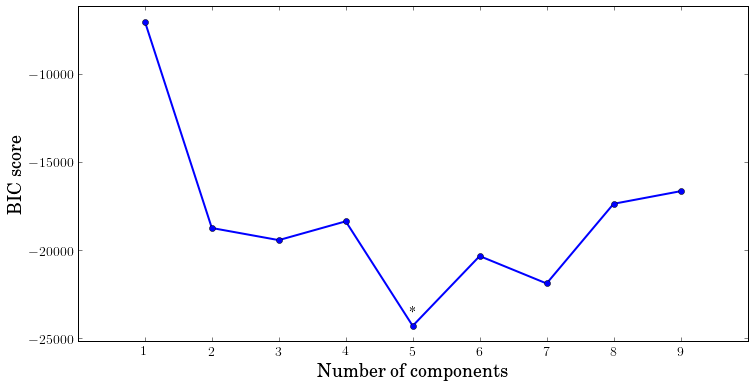

In [4]:
plot_bic(component_range, bics, optimal_n_comp)

> Based on the results of the above test, the model with 5 components has the lowest BIC score and is the optimal choice. However, on different runs with the same dataset, the 6 and 7 component models have sometimes shown a lower BIC, and some testing indicates that the 7 component model provides a superior fit to the data. Thus, for the rest of the demo we will use 7 components in the model.


## Fitting a Model

Once we know how many components to use in the model, we can fit a model using that number of components using the `fit_model` function. Before fitting for this demo, we are going to split our SN dataset 65-35, with the larger subsample being used to fit the model and the smaller subsample providing a test sample that we can use to predict supernovae and compare with our predicted sample.

In [5]:
# Split the dataset 65/35:
X_train, X_test, Xerr_train, Xerr_test, R_param_train, R_param_test = \
    train_test_split(X, Xerr, R_params, test_size=0.35, random_state=42)

# Fit the model:
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=7)

Note how the `fit_model` function also saves the fit to a file for later re-use. If a model has already been fit, it can be read into an existing `Empiricist` worker, or a new `Empiricist` can be instantiated using the model, like this:

In [6]:
alternative = empiriciSN.Empiricist(model_file='demo_model.fit')

# Print the weights array for each object---they should be the same...
print empiricist.XDGMM.weights
print alternative.XDGMM.weights

[ 0.39926652  0.1110391   0.12987929  0.1279762   0.20557151  0.01380134
  0.01246604]
[ 0.39926652  0.1110391   0.12987929  0.1279762   0.20557151  0.01380134
  0.01246604]


## Predicting a Likely Supernova

For the rest of this demo we will show how to use a model that has been fit to predict realistic supernovae from known host quantities. 

Since some of the quantities used to fit the model require knowledge of the supernova location (e.g., local surface brightness), this is a multi-step process. 

* First, we will use a subset of the host properties to select a likely location. 

* Then we will compute the local surface brightness, and use the full set of host parameters to condition the XDGMM model and sample a realistic supernova.

The "test" sample generated above gives us a set of 482 host properties that we can use to fit supernovae, and a set of supernova properties to compare with our model fits.

### Selecting the SN location within the host galaxy

<!-- One desired function of this tool is to provide a realistic location for a supernova within a host, along with realistic supernova properties. However, our overall model is trained with both overall host properties, like color and redshift, and the local surface brightness at the location of the supernova. In order for our tool to allow the user to fit a supernova based on host photometry and a surface brightness profile, we have provided a way to select a location for the supernova based on a subset of host properties so that local surface brightness can be calculated, and then the full set of host properties can be used to condition the model to provide supernova properties. -->

The `get_logR` function:

* takes as input an array of host properties, an array of corresponding indices in the dataset that is being fit, and the index of the $\log{R/R_e}$ quantity in the dataset;

* conditions the model based on the input host properties; 

* and returns a value for $\log{R/R_e}$ that is sampled from the conditioned model. 

We built the function to accept any number of host parameters and any indices from the input data for its conditioning set in order to make it as general as possible. However, for this demo we will use the redshift of the host and its 10 $ugriz$ colors, but with a different set of data the separation could be fit for any properties by simply passing the correct indeces into `get_logR`. 

> The only restriction on the data being passed in is that the first 3 indices of the dataset are reserved for the 3 `SALT2` supernova properties; apart from that, any properties (at any index in the dataset) can be used.

In [7]:
# Get actual separations from dataset, for comparison:
logR_test = X_test[:,4]

# Predict a radial separation for each host:
np.random.seed(10)
cond_indices = np.array([3,5,6,7,8,9,10,11,12,13,14])
sample_logR = np.array([])

for x in X_test:
    r = empiricist.get_logR(cond_indices,4,x[cond_indices])
    sample_logR = np.append(sample_logR,r)

Now we have a set of test separations in units of log(R/Re) and a set of separations sampled from the model. These should have the same distribution when plotted.

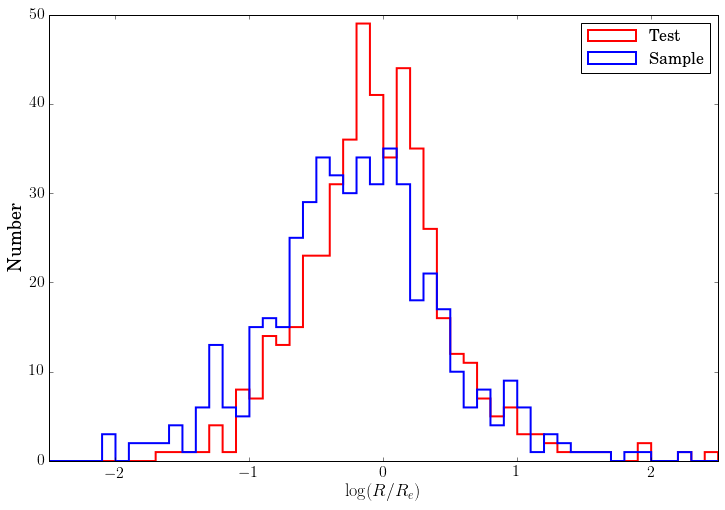

In [8]:
plot_separation(logR_test,sample_logR)

This predicted radial positions are in fairly good agreement with the training set. 

> With different training/test splits, the predicted distribution can be seen to move around a little within its width, as expected.


### Calculating Local Surface Brightness

Now that we have locations for each test SN, we can calculate the local surface brightness based on the appropriate surface brightness profile (Exponential or de Vaucouleurs) and the host magnitude and effective radius in each filter.

In order to save space here, the actual surface brightness calculation is done in the `get_local_SB` function in the accompanying `demo_funcs` file.

In [9]:
local_SB, local_SB_err = get_local_SB(R_param_test,sample_logR)

demo_funcs.py:216: RuntimeWarning: invalid value encountered in double_scalars
  (exp_unc/np.exp(-1.68*(r)))**2)


### Predicting Supernova Parameters

Now that we have the local surface brightnesses and separations, we can generate supernova parameters using our full range of host parameters (redshift, separation, colors, and local surface brightnesses). 

First, let's plot the distributions of supernova parameters in our test sample.

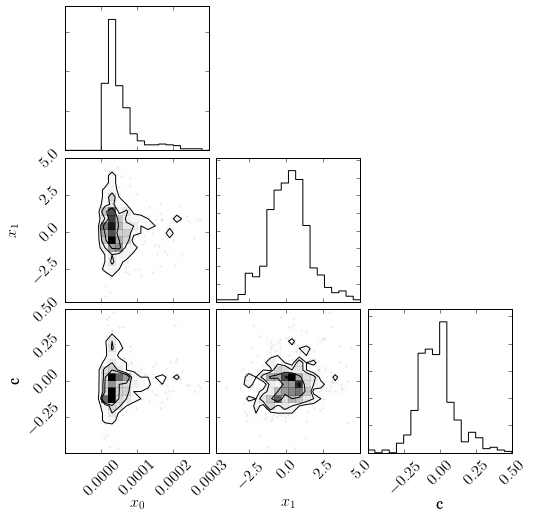

In [17]:
setup_text_plots(fontsize=16, usetex=True)
figure = corner.corner(X_test[:,0:3], labels=['$x_0$','$x_1$','c'],range=[(-0.0001,0.0003),(-4.7,5.0),(-0.5,0.5)])

Next we will use our host properties to predict a supernova for each host, then plot those with the test sample. Ideally, these distributions should be the same as those from the test sample.

In [18]:
# Set up an array to contain the new supernova properties:
n_Hosts = len(sample_logR)
sample_SNe = np.zeros([n_Hosts,3])

np.random.seed(2)

# Loop over host galaxies, conditioning on each one's properties and drawing one supernova:
for i in range(n_Hosts):
    
    x = np.append(X_test[i][3],sample_logR[i])
    x = np.append(x,X_test[i][5:15])
    x = np.append(x,local_SB[i])
    x = np.append(np.array([np.nan,np.nan,np.nan]),x)
    
    xerr = np.append(np.array([0.0,0.0,0.0]),Xerr_test[i,3,3])
    xerr = np.append(xerr,0.0)
    for j in range(5,15):
        xerr = np.append(xerr,Xerr_test[i,j,j])
    xerr = np.append(xerr,local_SB_err[i])
    
    sample_SNe[i] = empiricist.get_SN(x, Xerr=xerr, n_SN=1)

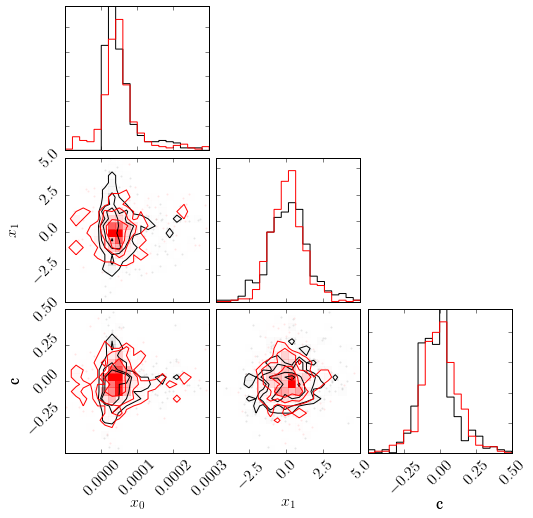

In [19]:
# Plot the SNe parameters:
corner.corner(sample_SNe[:,0:3], labels=['$x_0$','$x_1$','c'], color='red',
                                 fig=figure, range=[(-0.0001,0.0003),(-4.7,5.0),(-0.5,0.5)])

Not too bad overall. Given a larger test sample, this would likely look a bit better, but we are dealing with fairly small sample sizes.

Finally, let's take a look at the distribution of properties for a single radius in a single host galaxy. By sampling 1000 different supernovae at that position, we can see how the model has been conditioned to that host. We should see a significantly different distribution of supernova parameters from the previous plot, if supernova properties depend on either their positions within their hosts, or their host's properties, or both.

In [20]:
# Choose one (host galaxy, radial position) combination:
i = 13

np.random.seed(0)

# Set up the conditioning data:
x = np.append(X_test[i][3], sample_logR[i])
x = np.append(x, X_test[i][5:15])
x = np.append(x, local_SB[i])
x = np.append(np.array([np.nan, np.nan, np.nan]), x)

xerr = np.append(np.array([0.0,0.0,0.0]), Xerr_test[i,3,3])
xerr = np.append(xerr, 0.0)
for j in range(5,15):
    xerr = np.append(xerr, Xerr_test[i,j,j])
xerr = np.append(xerr, local_SB_err[i])

# Draw a thousand SNe:
sample_SNe = empiricist.get_SN(x, Xerr=xerr, n_SN=1000)

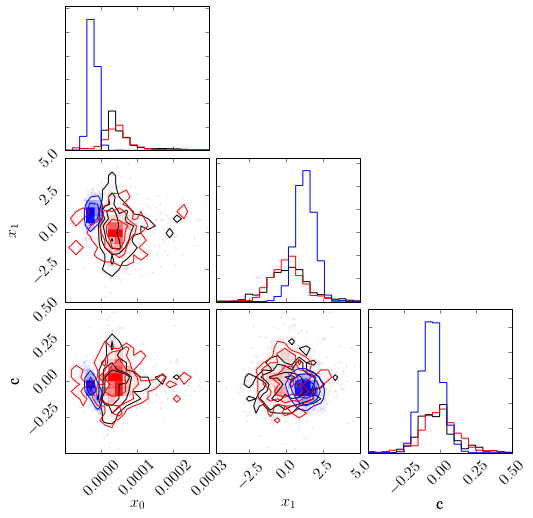

In [21]:
# Plot the SNe parameters:
corner.corner(sample_SNe[:,0:3], labels=['$x_0$','$x_1$','c'], color='blue',
                                 fig=figure, range=[(-0.0001,0.0003),(-4.7,5.0),(-0.5,0.5)])

As we can see, the distributions for the various properties can be quite different for a single position in a single host than what they are for the full sample: where the supernova happens, matters.